# Predict next stock price based on market sentiment
## And dispaly interpolated results

In [75]:
import numpy as np
import scipy as sci
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import math
from stock2 import getAndProcessFinancialDataJSON, getStockTickers
from stock3 import getAndProcessMultiFinancialDataJSON, getAndProcessMultiFinancialDataJSONSentiment
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, LSTM, BatchNormalization, LeakyReLU

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


# Data Preprocessing

In [41]:
# Get stock data from the internet

# Get 20 random tickers from NYSE
tickers = getStockTickers(20)
tickers = ["PBF", "TSLA", "ZM", "FLO", "SQ", "GPS", "VTRS", "LNC", "NRG", "ETSY"]
sentiment = [1, -1, -1, 1, -1, 1, 1, 1,-1, -1]
sentiment = [1, 0, 0, 1, 0, 1, 1, 1,-1, 0]

#sentiment = [0, 0,  0,  0,  0, 0, 0, 0, 0,  0]

#tickers = ["AMD"]
# get stock data from those tickers
X_raw,y_raw = getAndProcessMultiFinancialDataJSONSentiment(tickers,sentiment, look_fwd=1, interval="2m", rge="1mo", simple=False)

#X_raw,y_raw = getAndProcessFinancialDataJSON("AMD",look_fwd=2)
print(tickers)
print("Data size: ",len(X_raw))

Loading data using URL [ https://query1.finance.yahoo.com/v8/finance/chart/PBF?interval=2m&range=1mo ]
Loading data using URL [ https://query1.finance.yahoo.com/v8/finance/chart/TSLA?interval=2m&range=1mo ]
Loading data using URL [ https://query1.finance.yahoo.com/v8/finance/chart/ZM?interval=2m&range=1mo ]
Loading data using URL [ https://query1.finance.yahoo.com/v8/finance/chart/FLO?interval=2m&range=1mo ]
Loading data using URL [ https://query1.finance.yahoo.com/v8/finance/chart/SQ?interval=2m&range=1mo ]
Loading data using URL [ https://query1.finance.yahoo.com/v8/finance/chart/GPS?interval=2m&range=1mo ]
Loading data using URL [ https://query1.finance.yahoo.com/v8/finance/chart/VTRS?interval=2m&range=1mo ]
Loading data using URL [ https://query1.finance.yahoo.com/v8/finance/chart/LNC?interval=2m&range=1mo ]
Loading data using URL [ https://query1.finance.yahoo.com/v8/finance/chart/NRG?interval=2m&range=1mo ]
Loading data using URL [ https://query1.finance.yahoo.com/v8/finance/char

In [42]:
unix_time = getAndProcessFinancialDataJSON(tickers[0],justTimes=True)
# print(unix_time)

Loading data using URL [ https://query1.finance.yahoo.com/v8/finance/chart/PBF?interval=2m&range=1d ]


In [43]:
# Transformation functions
def transform_foward(array_2d):

    scaler_2 = MinMaxScaler(feature_range=(0, 1))
    result = np.array(array_2d)
    result_cols = scaler_2.fit_transform(array_2d.transpose()[1].reshape(-1, 1))
    result[:,1] = result_cols.reshape(-1,)

    return (result.astype('float32'),scaler_2)


# does not get you your sentiment back
def transform_back(result_2d, scaler):

    result = np.array(result_2d)
    result_cols = scaler.inverse_transform(result_2d.transpose()[1].reshape(-1, 1))
    return result_cols.transpose()[0].astype('float32')

# input a 2d [[senti, result]] array
def transform_back_single(result_nested_arrays, scaler):
    result_cols = scaler.inverse_transform(result_nested_arrays[0].reshape(-1, 1))
    return result_cols.transpose()[0][1].astype('float32')

In [44]:
X_raw_numpy = X_raw.to_numpy()
y_raw_numpy = y_raw.to_numpy()

In [45]:
# clean data
delete_list = []
for i in range(len(X_raw_numpy)):
    if(y_raw_numpy[i] == None):
        delete_list.append(i)
    for j in range(len(X_raw_numpy[0])):
        if(X_raw_numpy[i][j] == None):
            delete_list.append(i)
X_clean = np.delete(X_raw_numpy, delete_list, 0)
y_clean = np.delete(y_raw_numpy, delete_list, 0)
# np.isnan(y_raw[i])

print("original size:",len(y_raw))
print("elements to delete:",len(delete_list))
print("resulting size:",len(y_clean))
print("result+delete size:",len(y_clean) + len(delete_list))

original size: 42909
elements to delete: 228
resulting size: 42691
result+delete size: 42919


In [46]:
print(X_clean)
print(y_clean)
print(len(X_clean))
print(len(y_clean))

[[1.0 14.3100004196167]
 [1.0 14.270000457763672]
 [1.0 14.244999885559082]
 ...
 [0.0 163.0449981689453]
 [0.0 162.9243927001953]
 [0.0 163.0800018310547]]
[[14.270000457763672]
 [14.244999885559082]
 [14.279999732971191]
 ...
 [162.9243927001953]
 [163.0800018310547]
 [163.1199951171875]]
42691
42691


In [47]:
# Split into train, validate, and test sets
size = len(X_clean)

# Get test size and data
total_train_size = (size*8)//10
test_size = size - total_train_size

X_total_train_unnorm = X_clean[:total_train_size]
y_total_train_unnorm = y_clean[:total_train_size]

X_test_unnorm = X_clean[total_train_size:]
y_test_unnorm = y_clean[total_train_size:]

# Get train and validation size and data
train_size = (total_train_size*8)//10
val_size = total_train_size - train_size

X_train_unnorm = X_total_train_unnorm[:train_size]
y_train_unnorm = y_total_train_unnorm[:train_size]

X_val_unnorm = X_total_train_unnorm[train_size:]
y_val_unnorm = y_total_train_unnorm[train_size:]



In [48]:
print("Total set size:",total_train_size)
print("Training size:",train_size)
print("Validation Size:",val_size)
print("Test size:", test_size)
print()
print("Sanity checks:")
print(total_train_size == len(X_total_train_unnorm) == len(y_total_train_unnorm))
print(train_size == len(X_train_unnorm) == len(y_train_unnorm))
print(val_size == len(X_val_unnorm) == len(y_val_unnorm))
print(test_size == len(X_test_unnorm) == len(y_test_unnorm))
print()

Total set size: 34152
Training size: 27321
Validation Size: 6831
Test size: 8539

Sanity checks:
True
True
True
True



In [49]:
# Scale between 0 and 1, best for LSTM models

scaler = MinMaxScaler(feature_range=(0, 1))

X_train_norm,scaler = transform_foward(X_train_unnorm)
y_train_norm = scaler.fit_transform(y_train_unnorm)

X_val_norm,scaler = transform_foward(X_val_unnorm)
y_val_norm = scaler.fit_transform(y_val_unnorm)

X_test_norm,scaler_X = transform_foward(X_test_unnorm)
y_test_norm = scaler.fit_transform(y_test_unnorm)

In [50]:
# Let's try transposing y...
y = y_train_norm.transpose()[0]
y_val = y_val_norm.transpose()[0]
y_test = y_test_norm.transpose()[0]

In [51]:
# LSTM also needs to adhere to this shape
X =      np.reshape(X_train_norm, (     X_train_norm.shape[0],  1, X_train_norm.shape[1]))
X_val =  np.reshape(X_val_norm,   (     X_val_norm.shape[0],    1, X_val_norm.shape[1]))
X_test = np.reshape(X_test_norm,  (     X_test_norm.shape[0],   1, X_test_norm.shape[1]))
# y =      np.reshape(y_train_norm, (     y_train_norm.shape[0],  -1, y_train_norm.shape[1]))  # y_train_norm  
# y_val =  np.reshape(y_val_norm,   (     y_val_norm.shape[0],    -1, y_val_norm.shape[1]))    # y_val_norm
# y_test = np.reshape(y_test_norm,  (     y_test_norm.shape[0],   -1, y_test_norm.shape[1]))   # y_test_norm  

In [52]:
# Prints for sanity
print(X[0])
print(y)


print(len(X))
print(len(y))

[[1.         0.00306799]]
[0.00301393 0.00298014 0.00302744 ... 0.00175024 0.00171645 0.00170294]
27321
27321


# Model Creation 

In [53]:
# create the LSTM model
input_shape = (1,  2)
model = Sequential()

model.add(LSTM(512, input_shape=input_shape, return_sequences=True)) #, return_sequences=True))
model.add(LSTM(128)) #, return_sequences=True))

# Shape = [# of elements, data per element (1)]
#model.add(Dense(128, activation='tanh',kernel_regularizer=tf.keras.regularizers.L1(0.01),activity_regularizer=tf.keras.regularizers.L2(0.01)))
#model.add(BatchNormalization())
model.add(Dense(64, activation=LeakyReLU(),kernel_regularizer=tf.keras.regularizers.L1(0.01),activity_regularizer=tf.keras.regularizers.L2(0.01)))
model.add(Dense(16, activation=LeakyReLU()))
model.add(Dense(1))
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=["mse"])

model.summary()

# mean square error r2 regularization - use regressions

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1, 512)            1054720   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               328192    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 1,392,225
Trainable params: 1,392,225
Non-trainable params: 0
_________________________________________________________________


# Training

In [78]:
# Train
history = model.fit(X, y, epochs=11, batch_size=64, verbose=1, validation_data=(X_val, y_val))
print("Done!")

Epoch 1/11
427/427 [==============================] - 2s 3ms/step - loss: 0.2997 - mse: 9.6720e-05 - val_loss: 0.2648 - val_mse: 0.0022
Epoch 2/11
427/427 [==============================] - 2s 4ms/step - loss: 0.2981 - mse: 1.0081e-04 - val_loss: 0.3151 - val_mse: 0.0036
Epoch 3/11
427/427 [==============================] - 1s 3ms/step - loss: 0.2969 - mse: 1.1084e-04 - val_loss: 0.3616 - val_mse: 0.0046
Epoch 4/11
427/427 [==============================] - 2s 4ms/step - loss: 0.2960 - mse: 1.1440e-04 - val_loss: 0.4368 - val_mse: 0.0061
Epoch 5/11
427/427 [==============================] - 1s 3ms/step - loss: 0.2952 - mse: 1.1179e-04 - val_loss: 0.4080 - val_mse: 0.0058
Epoch 6/11
427/427 [==============================] - 1s 3ms/step - loss: 0.2945 - mse: 1.0592e-04 - val_loss: 0.6121 - val_mse: 0.0070
Epoch 7/11
427/427 [==============================] - 2s 4ms/step - loss: 0.2939 - mse: 9.5992e-05 - val_loss: 0.6835 - val_mse: 0.0073
Epoch 8/11
427/427 [============================

# Model Training Results

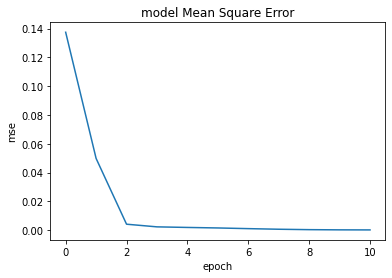

In [55]:
# plot mean square error
plt.plot(history.history['mse'])
plt.title('model Mean Square Error')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.show()


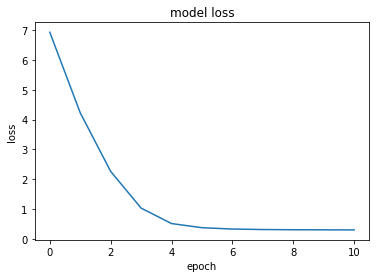

In [56]:
# plot loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [57]:
predictions = model(X_test)
print(predictions)

tf.Tensor(
[[0.11649156]
 [0.11699016]
 [0.1171567 ]
 ...
 [0.7195556 ]
 [0.71892494]
 [0.71973866]], shape=(8539, 1), dtype=float32)


In [58]:
model_guess = scaler_X.inverse_transform(predictions)
real_answer = scaler.inverse_transform([y_test])

In [59]:
testScore = math.sqrt(mean_squared_error(real_answer[0], model_guess[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 13.50 RMSE


# Next minute test

In [60]:
X_raw_2,y_raw_2 = getAndProcessMultiFinancialDataJSONSentiment(["GOOG"],[1],look_fwd=1, interval="2m", rge="1mo",simple=False)
X_raw_numpy_2 = X_raw_2.to_numpy() # np.array([[1,i] for i in range(1000)])
y_raw_numpy_2 = y_raw_2.to_numpy() # np.array([[-i,] for i in range(1000)])

# clean data
delete_list = []
for i in range(len(X_raw_numpy_2)):
    if(y_raw_numpy_2[i] == None):
        delete_list.append(i)
    for j in range(len(X_raw_numpy_2[0])):
        if(X_raw_numpy_2[i][j] == None):
            delete_list.append(i)
X_clean_2 = np.delete(X_raw_numpy_2, delete_list, 0)
actual_google_price = np.delete(y_raw_numpy_2, delete_list, 0)
actual_google_price = actual_google_price.astype(np.float)
scaler_2 = MinMaxScaler(feature_range=(0, 1))
X_train_norm_2 = scaler_2.fit_transform(X_clean_2)
not_needed = scaler_2.fit_transform(actual_google_price)

X_2 =      np.reshape(X_train_norm_2, (     X_train_norm_2.shape[0],  1, X_train_norm_2.shape[1]))


Loading data using URL [ https://query1.finance.yahoo.com/v8/finance/chart/GOOG?interval=2m&range=1mo ]


In [61]:
print(X_2[0])

[[0.         0.13765262]]


In [62]:
predicted_price = model(X_2)

In [63]:
predicted_google_price = scaler_2.inverse_transform(predicted_price)

Text(0.5, 0, 'Time (delta = 2 minutes)')

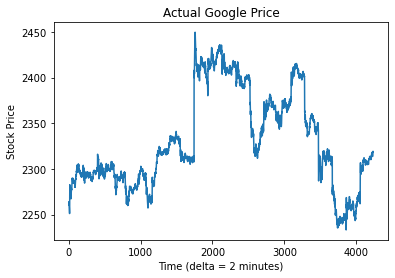

In [64]:
plt.plot(actual_google_price)
plt.title("Actual Google Price")
plt.ylabel("Stock Price")
plt.xlabel("Time (delta = 2 minutes)")

Text(0.5, 0, 'Time (delta = 2 minutes)')

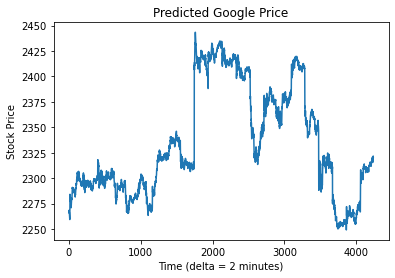

In [65]:
plt.plot(predicted_google_price)
plt.title("Predicted Google Price")
plt.ylabel("Stock Price")
plt.xlabel("Time (delta = 2 minutes)")

# Interpolate Stock Prices

In [73]:
X_raw_2,y_raw_2 = getAndProcessMultiFinancialDataJSONSentiment(["GOOG"],[1],look_fwd=1, interval="1m", rge="1mo",simple=False)
X_raw_numpy_2 = X_raw_2.to_numpy() # np.array([[1,i] for i in range(1000)])
y_raw_numpy_2 = y_raw_2.to_numpy() # np.array([[-i,] for i in range(1000)])

# clean data
delete_list = []
for i in range(len(X_raw_numpy_2)):
    if(y_raw_numpy_2[i] == None):
        delete_list.append(i)
    for j in range(len(X_raw_numpy_2[0])):
        if(X_raw_numpy_2[i][j] == None):
            delete_list.append(i)
X_clean_2 = np.delete(X_raw_numpy_2, delete_list, 0)
actual_google_price = np.delete(y_raw_numpy_2, delete_list, 0)
actual_google_price = actual_google_price.astype(np.float)

X_train_norm_2, scaler_2_back = transform_foward(X_clean_2)

not_needed = scaler_2.fit_transform(actual_google_price)
X_2 =      np.reshape(X_train_norm_2, (     X_train_norm_2.shape[0],  1, X_train_norm_2.shape[1]))

Loading data using URL [ https://query1.finance.yahoo.com/v8/finance/chart/GOOG?interval=2m&range=1mo ]


Sentiment 1.0

Mean square error: 30.639991857012113


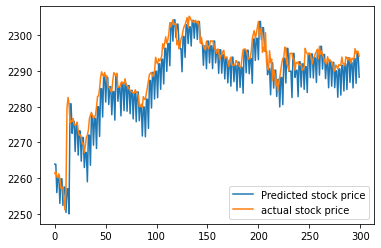

In [72]:
# Get sentiment
senti = X_2[0][0][0]
# senti = 0
print("Sentiment", senti)

# number of 2 minute steps into the future you want to predict into
steps = 300

# Will predict correcting itself every 2*interval seconds/minutes/hours/etc.
interpolation_numb = 3

# Set initial input
prev_price = np.array([X_2[0]])
# loop 

prices = []

for i in range(steps):
    print(f"step {i}",end='\r\r')
    # print(prev_price)
    prev_price.astype('float32')
    if (i % interpolation_numb == 0):
        prev_price = np.array([X_2[i]])
        unscaled = transform_back_single(prev_price[0], scaler_2_back)
        prices.append(unscaled)
    else:
        # use previous to predict next
        unscaled = transform_back_single(prev_price[0], scaler_2_back)
        prices.append(unscaled)

        # Predict

        next_price = model(prev_price)

        # Extract prediction
        next_point_val = next_price.numpy()[0][0]

        # generate a new numpy array with prediction and general sentiment
        simple_array = np.array([senti, next_point_val])

        prev_price = np.reshape(simple_array,(1,1,2))
print()
plt.plot(prices)
plt.plot(actual_google_price[:steps])
plt.legend(['Predicted stock price', 'actual stock price'])

# calculate error

predictions = np.array(actual_google_price[:steps].transpose()[0])
actual = np.array(prices)
mse = (np.square(predictions - actual)).mean(axis=None)
print("Mean square error:",mse)

- They way this is set up you would rather want longer range stock predictions than shorter range
- Beacuse as you keep going along before the next correct point, the accuracy drops 